# Asteroid Velocity Prior for Smart Stacking

## Motivation: Why Random Search is Wasteful

When detecting faint asteroids in survey data (e.g., Rubin/LSST), **matched filtering** or "smart stacking" requires searching over possible motion vectors. The naive approach searches all directions uniformly, treating the velocity space as isotropic.

**Key insight**: Known asteroid populations occupy **constrained regions** of orbital element space. At any sky position (RA, Dec) and time, objects from a given population will have a **predictable distribution of apparent sky-plane velocities**.

This notebook develops the mathematical framework and demonstrates that using population priors can reduce the search space by **~100x or more**.

## Mathematical Framework

### The Forward Problem

The chain of transformations from orbital elements to observed sky-plane velocity:

$$
\text{Orbital Elements } (a, e, i, \Omega, \omega, M) 
\xrightarrow{\text{Kepler}} 
\vec{r}_{\text{helio}}, \vec{v}_{\text{helio}}
\xrightarrow{-\vec{r}_\oplus} 
\vec{r}_{\text{geo}}, \vec{v}_{\text{geo}}
\xrightarrow{\text{project}} 
(\mu_\alpha \cos\delta, \mu_\delta)
$$

Where:
- $(a, e, i, \Omega, \omega, M)$ are the Keplerian orbital elements
- $\vec{r}_{\text{helio}}, \vec{v}_{\text{helio}}$ are heliocentric position and velocity
- $\vec{r}_\oplus$ is Earth's heliocentric position
- $(\mu_\alpha \cos\delta, \mu_\delta)$ is the apparent sky-plane velocity (proper motion)

### The Key Constraint

For a given sky position $(\alpha, \delta)$ and orbital shape $(a, e, i, \Omega, \omega)$, the mean anomaly $M$ that places the object at that position is **constrained** by the line-of-sight intersection with the orbit.

This means:
$$
p(\mu_\alpha, \mu_\delta | \alpha, \delta, t) = \int p(\mu | \text{elements}) \cdot p(\text{elements} | \alpha, \delta, t) \, d(\text{elements})
$$

The population prior $p(\text{elements})$ constrains which velocities are likely.

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.time import Time
import sys
from pathlib import Path

# Add parent directory to path
# Add current directory to path (for local development)
sys.path.insert(0, '.')

from asteroid_velocity_prior import (
    VelocityPriorCalculator,
    MainBeltPopulation,
    NEOPopulation,
    TNOPopulation,
    JupiterTrojanPopulation,
    compute_search_space_reduction,
    compute_sky_reduction_map,
)
from asteroid_velocity_prior.orbital_mechanics import (
    orbital_elements_to_state,
    GM_SUN,
    orbital_period,
)
from asteroid_velocity_prior.coordinates import (
    get_earth_position,
    geocentric_to_radec,
    geocentric_to_sky_velocity,
)

# Set random seed for reproducibility
rng = np.random.default_rng(42)

# Plotting style
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 11

print("Imports successful!")

Imports successful!


## Part 1: Understanding Orbital Mechanics

### 1.1 Orbital Elements to Position and Velocity

Let's trace through the computation for a single asteroid orbit.

The six Keplerian orbital elements are:
- $a$ - Semi-major axis [AU]
- $e$ - Eccentricity
- $i$ - Inclination [rad]
- $\Omega$ - Longitude of ascending node [rad]
- $\omega$ - Argument of perihelion [rad]
- $M$ - Mean anomaly [rad]

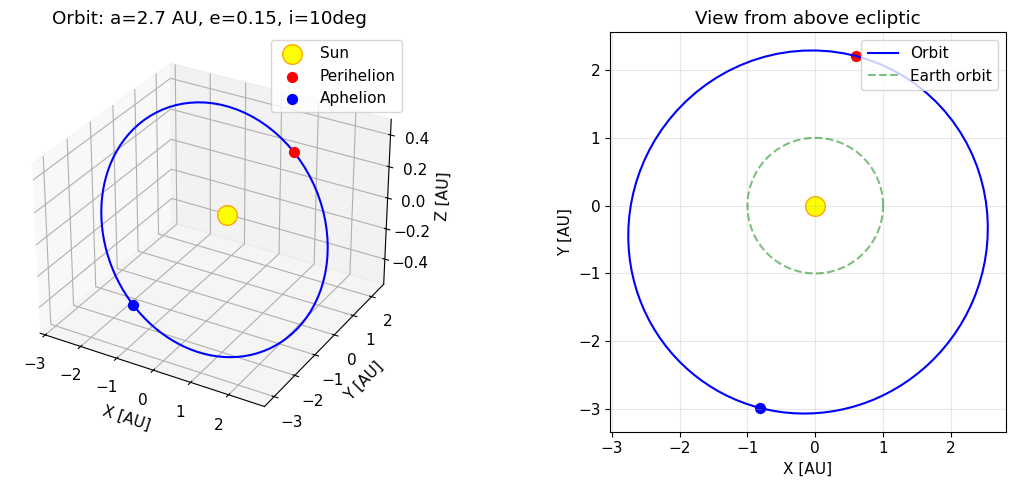

Orbital period: 1620.5 days = 4.44 years
Perihelion distance: 2.29 AU
Aphelion distance: 3.10 AU


In [2]:
# Example: A typical Main Belt asteroid
a = 2.7      # AU (middle of main belt)
e = 0.15     # moderate eccentricity
i = np.radians(10)   # 10 degree inclination
Omega = np.radians(45)  # ascending node
omega = np.radians(30)  # argument of perihelion

# Plot the orbit at different mean anomalies
M_values = np.linspace(0, 2*np.pi, 100)

positions = []
velocities = []
for M in M_values:
    r, v = orbital_elements_to_state(a, e, i, Omega, omega, M)
    positions.append(r)
    velocities.append(v)

positions = np.array(positions)
velocities = np.array(velocities)

# 3D plot of the orbit
fig = plt.figure(figsize=(12, 5))

# Left: 3D view
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', linewidth=1.5)
ax1.scatter([0], [0], [0], c='yellow', s=200, marker='o', edgecolors='orange', label='Sun')

# Mark perihelion and aphelion
r_peri, _ = orbital_elements_to_state(a, e, i, Omega, omega, 0)
r_aph, _ = orbital_elements_to_state(a, e, i, Omega, omega, np.pi)
ax1.scatter(*r_peri, c='red', s=50, marker='o', label='Perihelion')
ax1.scatter(*r_aph, c='blue', s=50, marker='o', label='Aphelion')

ax1.set_xlabel('X [AU]')
ax1.set_ylabel('Y [AU]')
ax1.set_zlabel('Z [AU]')
ax1.set_title(f'Orbit: a={a} AU, e={e}, i={np.degrees(i):.0f}deg')
ax1.legend()

# Right: ecliptic plane view (x-y)
ax2 = fig.add_subplot(122)
ax2.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=1.5, label='Orbit')
ax2.scatter([0], [0], c='yellow', s=200, marker='o', edgecolors='orange')
ax2.scatter(*r_peri[:2], c='red', s=50, marker='o')
ax2.scatter(*r_aph[:2], c='blue', s=50, marker='o')

# Earth's orbit (circular approximation)
theta = np.linspace(0, 2*np.pi, 100)
ax2.plot(np.cos(theta), np.sin(theta), 'g--', alpha=0.5, label='Earth orbit')

ax2.set_xlabel('X [AU]')
ax2.set_ylabel('Y [AU]')
ax2.set_title('View from above ecliptic')
ax2.set_aspect('equal')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Orbital period: {orbital_period(a):.1f} days = {orbital_period(a)/365.25:.2f} years")
print(f"Perihelion distance: {a*(1-e):.2f} AU")
print(f"Aphelion distance: {a*(1+e):.2f} AU")

### 1.2 From Heliocentric to Geocentric: Observer Perspective

What we observe from Earth is the **geocentric** position and velocity. The transformation is:

$$\vec{r}_{\text{geo}} = \vec{r}_{\text{helio}} - \vec{r}_\oplus$$

$$\vec{v}_{\text{geo}} = \vec{v}_{\text{helio}} - \vec{v}_\oplus$$

Earth position (ecliptic): [-9.96023866e-01 -3.50524677e-04  3.56004789e-06]
Earth velocity (ecliptic): [-2.70230679e-04 -1.72755241e-02  5.82198231e-07] AU/day
Earth distance from Sun: 0.9960 AU


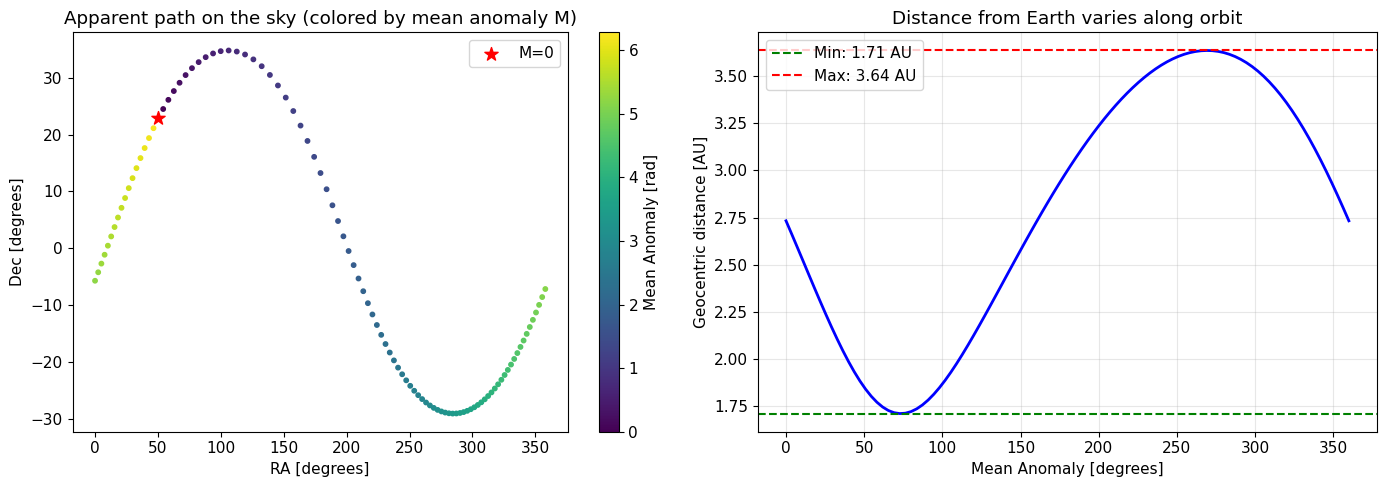

In [3]:
# Get Earth's position at a specific time
obs_time = Time('2026-03-21')  # Spring equinox
r_earth, v_earth = get_earth_position(obs_time)

print(f"Earth position (ecliptic): {r_earth}")
print(f"Earth velocity (ecliptic): {v_earth} AU/day")
print(f"Earth distance from Sun: {np.linalg.norm(r_earth):.4f} AU")

# Compute geocentric positions for our example orbit
geo_positions = positions - r_earth
geo_velocities = velocities - v_earth

# Convert to RA, Dec
ra_values = []
dec_values = []
dist_values = []

for r_geo in geo_positions:
    ra, dec, dist = geocentric_to_radec(r_geo, degrees=True)
    ra_values.append(ra)
    dec_values.append(dec)
    dist_values.append(dist)

ra_values = np.array(ra_values)
dec_values = np.array(dec_values)
dist_values = np.array(dist_values)

# Plot the apparent path on the sky
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: RA vs Dec (sky path)
ax = axes[0]
sc = ax.scatter(ra_values, dec_values, c=M_values, cmap='viridis', s=10)
ax.set_xlabel('RA [degrees]')
ax.set_ylabel('Dec [degrees]')
ax.set_title('Apparent path on the sky (colored by mean anomaly M)')
plt.colorbar(sc, ax=ax, label='Mean Anomaly [rad]')
ax.scatter(ra_values[0], dec_values[0], c='red', s=100, marker='*', label='M=0')
ax.legend()

# Right: geocentric distance vs M
ax = axes[1]
ax.plot(np.degrees(M_values), dist_values, 'b-', linewidth=2)
ax.set_xlabel('Mean Anomaly [degrees]')
ax.set_ylabel('Geocentric distance [AU]')
ax.set_title('Distance from Earth varies along orbit')
ax.axhline(np.min(dist_values), color='g', linestyle='--', label=f'Min: {np.min(dist_values):.2f} AU')
ax.axhline(np.max(dist_values), color='r', linestyle='--', label=f'Max: {np.max(dist_values):.2f} AU')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.3 Sky-Plane Velocity (Proper Motion)

The apparent velocity on the sky is computed by projecting the geocentric velocity onto the tangent plane:

$$\mu_\alpha \cos\delta = \frac{\vec{v}_{\text{geo}} \cdot \hat{e}_\alpha}{|\vec{r}_{\text{geo}}|}$$

$$\mu_\delta = \frac{\vec{v}_{\text{geo}} \cdot \hat{e}_\delta}{|\vec{r}_{\text{geo}}|}$$

Where $\hat{e}_\alpha$ points East and $\hat{e}_\delta$ points North.

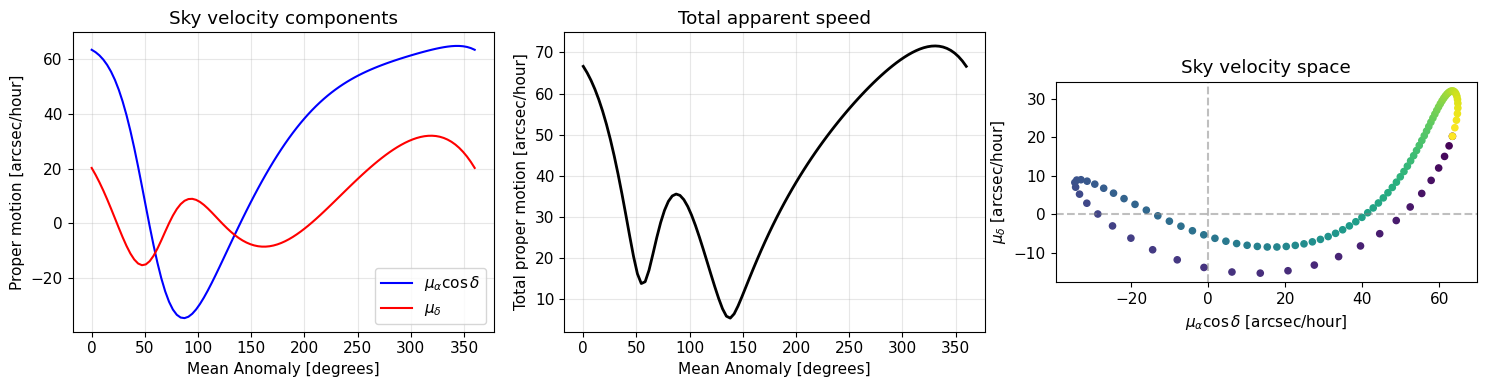

Speed range: 5.4 - 71.6 arcsec/hour


In [4]:
# Compute sky velocities along the orbit
mu_ra_values = []
mu_dec_values = []

for r_geo, v_geo in zip(geo_positions, geo_velocities):
    mu_ra, mu_dec, _ = geocentric_to_sky_velocity(r_geo, v_geo)
    mu_ra_values.append(mu_ra)
    mu_dec_values.append(mu_dec)

mu_ra_values = np.array(mu_ra_values)
mu_dec_values = np.array(mu_dec_values)
mu_total = np.sqrt(mu_ra_values**2 + mu_dec_values**2)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(np.degrees(M_values), mu_ra_values, 'b-', label=r'$\mu_\alpha \cos\delta$')
ax.plot(np.degrees(M_values), mu_dec_values, 'r-', label=r'$\mu_\delta$')
ax.set_xlabel('Mean Anomaly [degrees]')
ax.set_ylabel('Proper motion [arcsec/hour]')
ax.set_title('Sky velocity components')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(np.degrees(M_values), mu_total, 'k-', linewidth=2)
ax.set_xlabel('Mean Anomaly [degrees]')
ax.set_ylabel('Total proper motion [arcsec/hour]')
ax.set_title('Total apparent speed')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.scatter(mu_ra_values, mu_dec_values, c=M_values, cmap='viridis', s=20)
ax.set_xlabel(r'$\mu_\alpha \cos\delta$ [arcsec/hour]')
ax.set_ylabel(r'$\mu_\delta$ [arcsec/hour]')
ax.set_title('Sky velocity space')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"Speed range: {mu_total.min():.1f} - {mu_total.max():.1f} arcsec/hour")

## Part 2: Population Priors

### 2.1 Different Asteroid Populations

| Population | Semi-major axis | Eccentricity | Inclination |
|------------|-----------------|--------------|-------------|
| Main Belt  | 2.1 - 3.3 AU    | 0 - 0.4      | 0 - 30 deg  |
| NEOs       | 0.5 - 4 AU      | 0 - 0.95     | 0 - 90 deg  |
| Trojans    | ~5.2 AU         | 0 - 0.2      | 0 - 40 deg  |
| TNOs       | 30 - 50 AU      | 0 - 0.3      | 0 - 30 deg  |

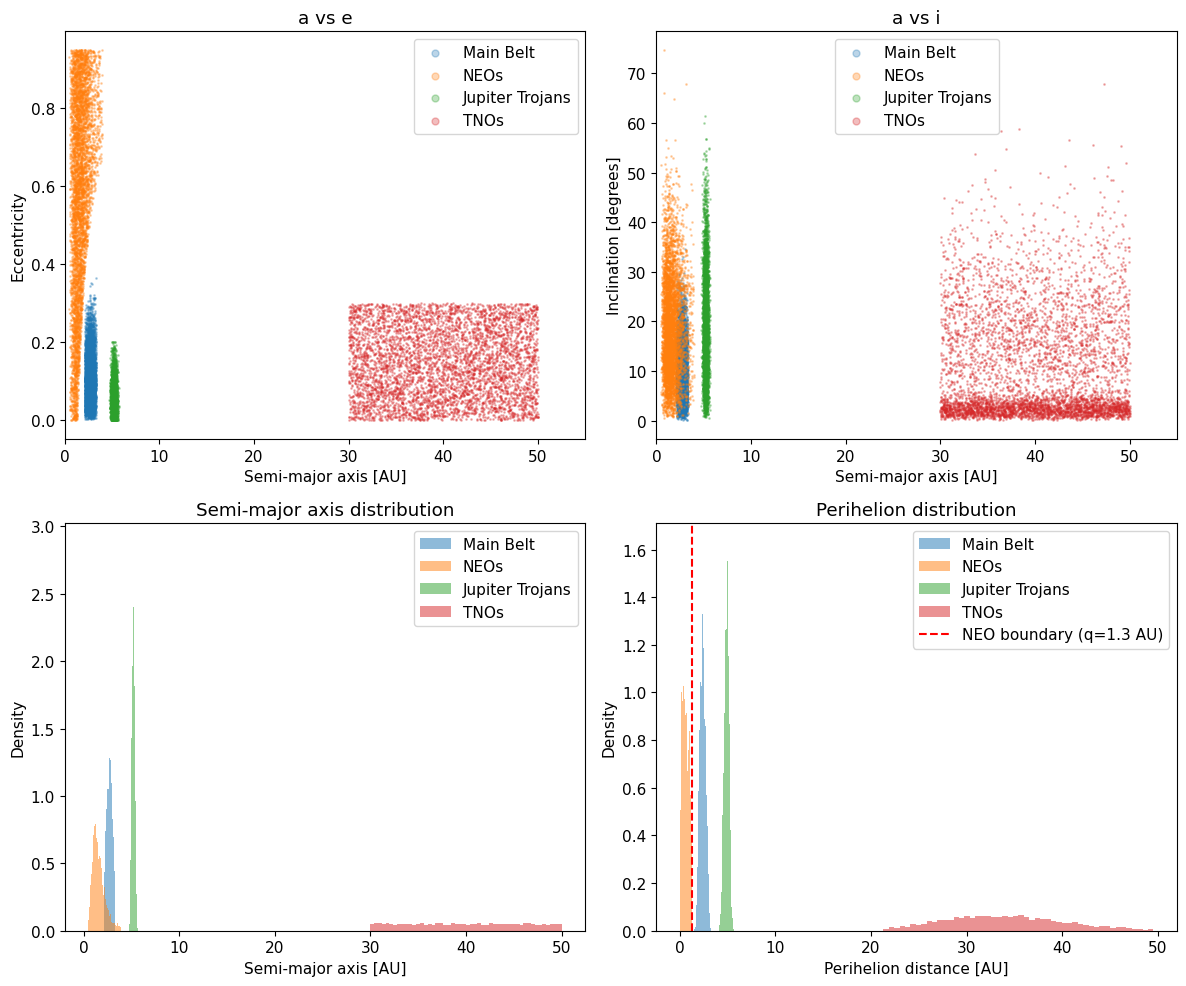

In [5]:
# Sample from each population
populations = {
    'Main Belt': MainBeltPopulation(),
    'NEOs': NEOPopulation(),
    'Jupiter Trojans': JupiterTrojanPopulation(),
    'TNOs': TNOPopulation(),
}

n_samples = 5000
colors = ['C0', 'C1', 'C2', 'C3']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

samples = {}
for (name, pop), color in zip(populations.items(), colors):
    samples[name] = pop.sample(n_samples, rng)

# a vs e
ax = axes[0, 0]
for (name, s), color in zip(samples.items(), colors):
    ax.scatter(s.a, s.e, s=1, alpha=0.3, c=color, label=name)
ax.set_xlabel('Semi-major axis [AU]')
ax.set_ylabel('Eccentricity')
ax.set_title('a vs e')
ax.legend(markerscale=5)
ax.set_xlim(0, 55)

# a vs i
ax = axes[0, 1]
for (name, s), color in zip(samples.items(), colors):
    ax.scatter(s.a, np.degrees(s.i), s=1, alpha=0.3, c=color, label=name)
ax.set_xlabel('Semi-major axis [AU]')
ax.set_ylabel('Inclination [degrees]')
ax.set_title('a vs i')
ax.legend(markerscale=5)
ax.set_xlim(0, 55)

# a histogram
ax = axes[1, 0]
for (name, s), color in zip(samples.items(), colors):
    ax.hist(s.a, bins=50, alpha=0.5, density=True, color=color, label=name)
ax.set_xlabel('Semi-major axis [AU]')
ax.set_ylabel('Density')
ax.set_title('Semi-major axis distribution')
ax.legend()

# Perihelion q = a(1-e)
ax = axes[1, 1]
for (name, s), color in zip(samples.items(), colors):
    q = s.a * (1 - s.e)
    ax.hist(q, bins=50, alpha=0.5, density=True, color=color, label=name)
ax.set_xlabel('Perihelion distance [AU]')
ax.set_ylabel('Density')
ax.set_title('Perihelion distribution')
ax.axvline(1.3, color='red', linestyle='--', label='NEO boundary (q=1.3 AU)')
ax.legend()

plt.tight_layout()
plt.show()

## Part 3: Computing Velocity Priors

### 3.1 The Algorithm

Given a target sky position $(\alpha, \delta)$, time $t$, and population prior:

1. Sample orbital elements from the population prior
2. For each sample, uniformly sample mean anomaly $M$
3. Compute heliocentric state -> geocentric state -> (RA, Dec)
4. **Accept** samples where computed (RA, Dec) is within tolerance of target
5. For accepted samples, compute sky-plane velocity

In [6]:
# Compute velocity prior for Main Belt at opposition
print("Computing velocity prior for Main Belt at opposition...")

ra, dec = 180.0, 0.0  # Opposition point
obs_time = Time('2026-03-21')

population = MainBeltPopulation()
calc = VelocityPriorCalculator(population, rng=rng)

result = calc.compute_velocity_prior(
    ra, dec, obs_time,
    n_samples=10000,
    angular_tolerance=5.0,
)

print(f"Accepted {result.n_samples} samples")
print(f"Median speed: {np.median(result.mu_total):.1f} arcsec/hour")
print(f"Speed range: [{result.mu_total.min():.1f}, {result.mu_total.max():.1f}] arcsec/hour")

Computing velocity prior for Main Belt at opposition...


Accepted 10000 samples
Median speed: 34.8 arcsec/hour
Speed range: [27.5, 76.0] arcsec/hour


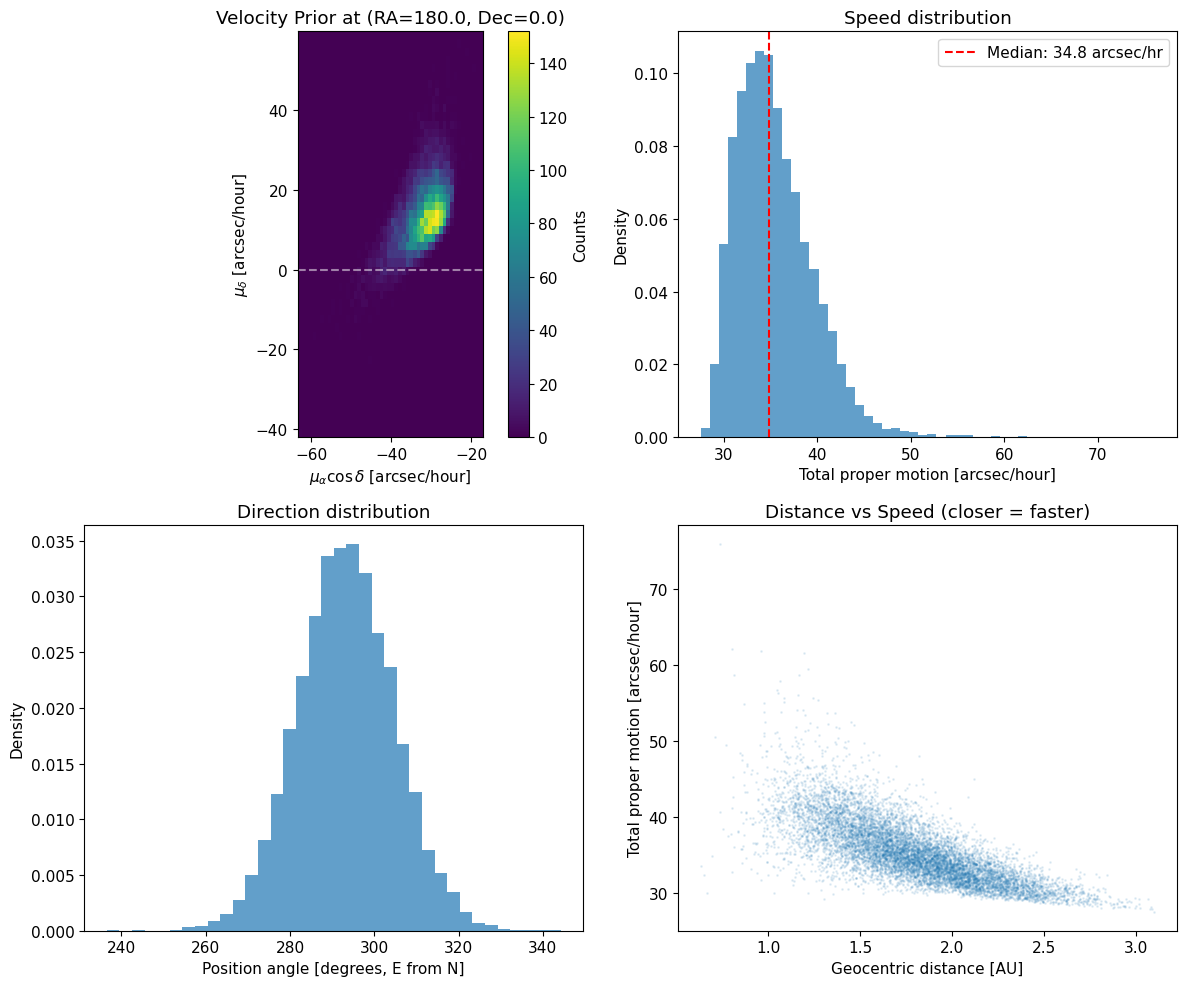

In [7]:
# Visualize the velocity prior
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax = axes[0, 0]
h = ax.hist2d(result.mu_ra_cosdec, result.mu_dec, bins=50, cmap='viridis')
ax.set_xlabel(r'$\mu_\alpha \cos\delta$ [arcsec/hour]')
ax.set_ylabel(r'$\mu_\delta$ [arcsec/hour]')
ax.set_title(f'Velocity Prior at (RA={ra}, Dec={dec})')
ax.axhline(0, color='white', linestyle='--', alpha=0.5)
ax.axvline(0, color='white', linestyle='--', alpha=0.5)
ax.set_aspect('equal')
plt.colorbar(h[3], ax=ax, label='Counts')

ax = axes[0, 1]
ax.hist(result.mu_total, bins=50, density=True, alpha=0.7, color='C0')
ax.axvline(np.median(result.mu_total), color='red', linestyle='--',
           label=f'Median: {np.median(result.mu_total):.1f} arcsec/hr')
ax.set_xlabel('Total proper motion [arcsec/hour]')
ax.set_ylabel('Density')
ax.set_title('Speed distribution')
ax.legend()

ax = axes[1, 0]
ax.hist(result.position_angle, bins=36, density=True, alpha=0.7, color='C0')
ax.set_xlabel('Position angle [degrees, E from N]')
ax.set_ylabel('Density')
ax.set_title('Direction distribution')

ax = axes[1, 1]
ax.scatter(result.geo_distance, result.mu_total, s=1, alpha=0.1)
ax.set_xlabel('Geocentric distance [AU]')
ax.set_ylabel('Total proper motion [arcsec/hour]')
ax.set_title('Distance vs Speed (closer = faster)')

plt.tight_layout()
plt.show()

### 3.2 Comparing Different Populations

In [8]:
print("Computing velocity priors for different populations...\n")

ra, dec = 180.0, 5.0
obs_time = Time('2026-03-21')

populations_to_compare = {
    'Main Belt': MainBeltPopulation(),
    'NEOs': NEOPopulation(),
    'Jupiter Trojans': JupiterTrojanPopulation(),
}

results = {}
for name, pop in populations_to_compare.items():
    calc = VelocityPriorCalculator(pop, rng=rng)
    try:
        results[name] = calc.compute_velocity_prior(
            ra, dec, obs_time, n_samples=5000, angular_tolerance=5.0,
        )
        print(f"{name}: {results[name].n_samples} samples, "
              f"median speed = {np.median(results[name].mu_total):.1f} arcsec/hour")
    except ValueError as e:
        print(f"{name}: {e}")
        results[name] = None

Computing velocity priors for different populations...



Main Belt: 5000 samples, median speed = 34.7 arcsec/hour


NEOs: 5000 samples, median speed = 53.2 arcsec/hour


Jupiter Trojans: 5000 samples, median speed = 20.4 arcsec/hour


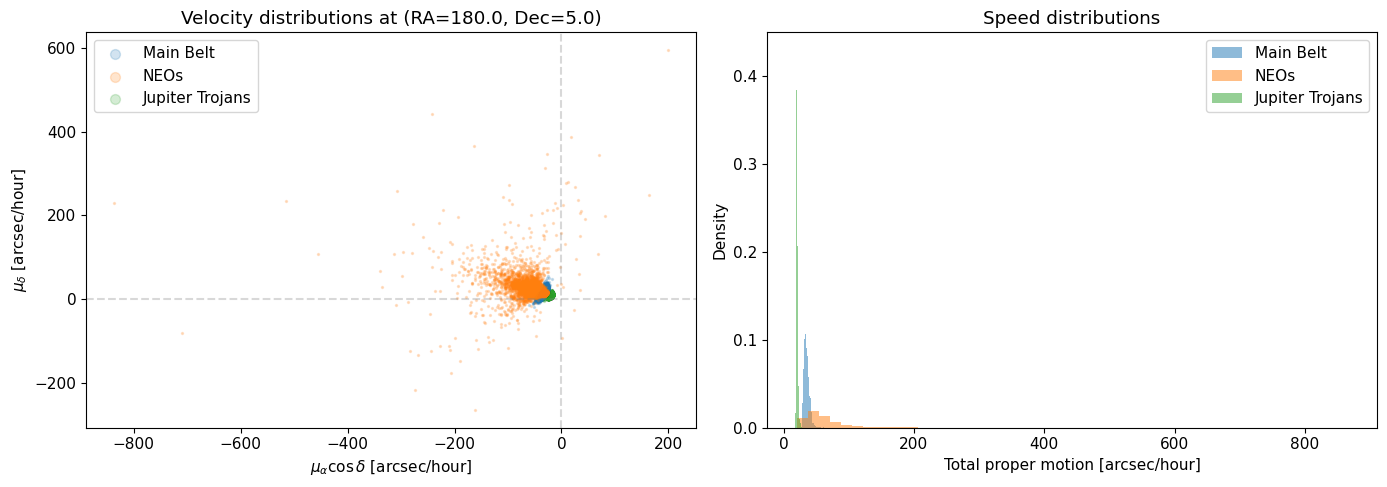

In [9]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'Main Belt': 'C0', 'NEOs': 'C1', 'Jupiter Trojans': 'C2'}

ax = axes[0]
for name, result in results.items():
    if result is not None:
        ax.scatter(result.mu_ra_cosdec, result.mu_dec, 
                   s=2, alpha=0.2, c=colors[name], label=name)
ax.set_xlabel(r'$\mu_\alpha \cos\delta$ [arcsec/hour]')
ax.set_ylabel(r'$\mu_\delta$ [arcsec/hour]')
ax.set_title(f'Velocity distributions at (RA={ra}, Dec={dec})')
ax.legend(markerscale=5)
ax.axhline(0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(0, color='gray', linestyle='--', alpha=0.3)

ax = axes[1]
for name, result in results.items():
    if result is not None:
        ax.hist(result.mu_total, bins=50, alpha=0.5, density=True,
                color=colors[name], label=name)
ax.set_xlabel('Total proper motion [arcsec/hour]')
ax.set_ylabel('Density')
ax.set_title('Speed distributions')
ax.legend()

plt.tight_layout()
plt.show()

## Part 4: Search Space Reduction

### 4.1 Quantifying the Gain

The **reduction factor** is:

$$R = \frac{\text{Uniform search space}}{\text{Prior-weighted search space (for X\% coverage)}}$$

In [10]:
# Compute search space reduction for Main Belt
result_mba = results['Main Belt']

stats = compute_search_space_reduction(
    result_mba,
    velocity_range=(-100, 100),
    n_bins=100,
    coverage_fraction=0.9,
)

print("Search Space Analysis for Main Belt Asteroids")
print("=" * 50)
print(f"Velocity search range: +/-100 arcsec/hour")
print(f"Grid resolution: {stats['uniform_cells']} cells (100x100)")
print(f"")
print(f"Uniform search: {stats['uniform_cells']} cells")
print(f"Prior-weighted (90% coverage): {stats['prior_cells']} cells")
print(f"")
print(f">>> REDUCTION FACTOR: {stats['reduction_factor']:.1f}x <<<")

Search Space Analysis for Main Belt Asteroids
Velocity search range: +/-100 arcsec/hour
Grid resolution: 10000 cells (100x100)

Uniform search: 10000 cells
Prior-weighted (90% coverage): 82 cells

>>> REDUCTION FACTOR: 122.0x <<<


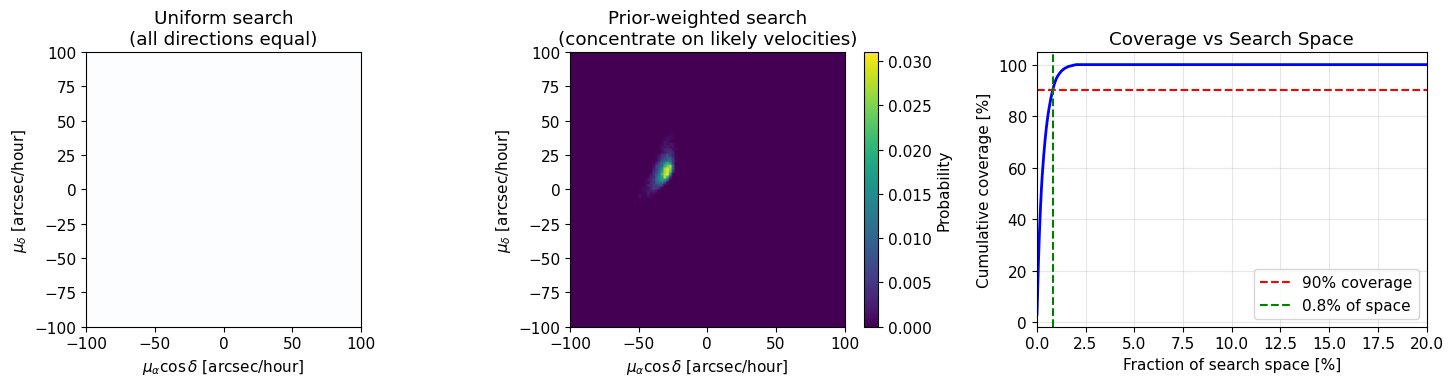

In [11]:
# Visualize the weight map
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
uniform = np.ones((100, 100))
ax.imshow(uniform, extent=[-100, 100, -100, 100], origin='lower', 
          cmap='Blues', alpha=0.3)
ax.set_xlabel(r'$\mu_\alpha \cos\delta$ [arcsec/hour]')
ax.set_ylabel(r'$\mu_\delta$ [arcsec/hour]')
ax.set_title('Uniform search\n(all directions equal)')
ax.set_aspect('equal')

ax = axes[1]
hist = stats['histogram']
edges = stats['bin_edges']
im = ax.imshow(hist.T, extent=[edges[0][0], edges[0][-1], edges[1][0], edges[1][-1]],
               origin='lower', cmap='viridis', aspect='equal')
ax.set_xlabel(r'$\mu_\alpha \cos\delta$ [arcsec/hour]')
ax.set_ylabel(r'$\mu_\delta$ [arcsec/hour]')
ax.set_title('Prior-weighted search\n(concentrate on likely velocities)')
plt.colorbar(im, ax=ax, label='Probability')

ax = axes[2]
flat_hist = hist.ravel()
sorted_probs = np.sort(flat_hist)[::-1]
cumsum = np.cumsum(sorted_probs)
n_cells = np.arange(1, len(cumsum) + 1)
fraction_of_space = n_cells / len(cumsum) * 100

ax.plot(fraction_of_space, cumsum * 100, 'b-', linewidth=2)
ax.axhline(90, color='red', linestyle='--', label='90% coverage')
ax.axvline(stats['prior_cells'] / stats['uniform_cells'] * 100, 
           color='green', linestyle='--',
           label=f"{stats['prior_cells']/stats['uniform_cells']*100:.1f}% of space")
ax.set_xlabel('Fraction of search space [%]')
ax.set_ylabel('Cumulative coverage [%]')
ax.set_title('Coverage vs Search Space')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 20)

plt.tight_layout()
plt.show()

## Part 5: Sky Map of Search Space Reduction

### 5.1 How Does the Reduction Vary Across the Sky?

The reduction factor depends on:
- **Solar elongation**: Objects at opposition vs quadrature have different velocity distributions
- **Ecliptic latitude**: Main Belt asteroids have low inclinations (~0-30°), so they appear mostly near the ecliptic plane
- **Earth's position**: Changes the geometry throughout the year

**Note**: Gray regions in the map indicate sky positions where Main Belt asteroids cannot appear due to their orbital inclination constraints. These regions would need to be searched for other populations (e.g., high-inclination NEOs or comets).

In [12]:
print("Computing sky map of search space reduction...")
print("(This may take a few minutes)\n")

# Higher resolution grid for better visualization
ra_grid = np.arange(0, 360, 10)    # Every 10 degrees in RA (36 points)
dec_grid = np.arange(-80, 85, 10)  # -80 to +80 in Dec (17 points)

obs_time = Time('2026-03-21')
population = MainBeltPopulation()

sky_reduction = compute_sky_reduction_map(
    population=population,
    time=obs_time,
    ra_grid=ra_grid,
    dec_grid=dec_grid,
    n_samples=2000,
    angular_tolerance=5.0,
    velocity_range=(-100, 100),
    coverage_fraction=0.9,
    rng=rng,
)

print(f"Grid size: {len(ra_grid)} x {len(dec_grid)} = {len(ra_grid)*len(dec_grid)} positions")
print("Done!")

Computing sky map of search space reduction...
(This may take a few minutes)



Grid size: 36 x 17 = 612 positions
Done!


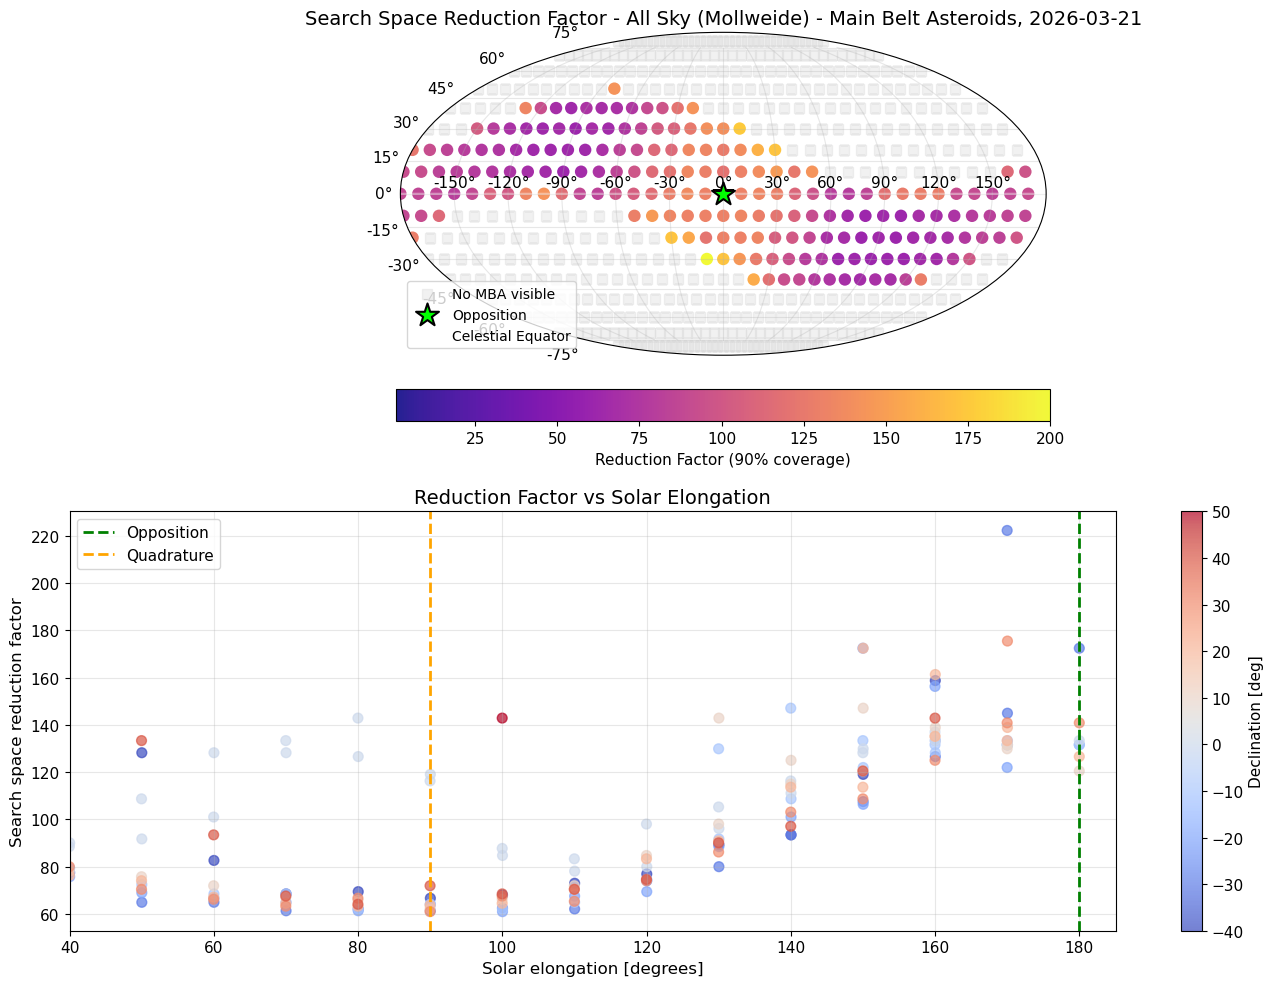

Summary Statistics for 191 valid sky positions:
  (Gray regions = MBA inclinations too low to appear there)
  Minimum reduction: 61.0x
  Maximum reduction: 222.2x
  Median reduction: 90.9x
  Mean reduction: 99.0x


In [13]:
# Plot the sky map using Mollweide projection (proper spherical projection)
fig = plt.figure(figsize=(14, 10))

reduction_map = sky_reduction['reduction_map']
valid_mask = sky_reduction['valid_mask']

r_earth, _ = get_earth_position(obs_time)
sun_ra = np.degrees(np.arctan2(-r_earth[1], -r_earth[0])) % 360
opposition_ra = (sun_ra + 180) % 360

# Mollweide all-sky projection
ax = fig.add_subplot(211, projection='mollweide')

# For Mollweide, RA needs to be in radians centered at 0 (range -pi to pi)
RA, DEC = np.meshgrid(ra_grid, dec_grid)
RA_rad = np.radians(RA - 180)  # Center at RA=180
DEC_rad = np.radians(DEC)

# Plot ALL grid points - gray for invalid (no MBA visible), colored for valid
all_ra = RA_rad.ravel()
all_dec = DEC_rad.ravel()
all_reduction = reduction_map.ravel()
all_valid = valid_mask.ravel()

# First plot invalid points as gray (regions where MBAs cannot appear)
invalid_ra = all_ra[~all_valid]
invalid_dec = all_dec[~all_valid]
ax.scatter(invalid_ra, invalid_dec, c='lightgray', s=60, marker='s', 
           alpha=0.3, label='No MBA visible')

# Then plot valid points with color
valid_ra = all_ra[all_valid]
valid_dec = all_dec[all_valid]
valid_reduction = all_reduction[all_valid]

sc = ax.scatter(valid_ra, valid_dec, c=valid_reduction, cmap='plasma', 
                s=80, vmin=1, vmax=200, edgecolors='none', alpha=0.9)

# Mark opposition point
opp_ra_rad = np.radians(opposition_ra - 180)
ax.scatter([opp_ra_rad], [0], c='lime', s=300, marker='*', 
           edgecolors='black', linewidths=1.5, zorder=10, label='Opposition')

# Draw ecliptic (Dec~0 is celestial equator; ecliptic is tilted ~23.4 deg)
# For simplicity, show celestial equator
ecl_ra = np.linspace(-np.pi, np.pi, 100)
ax.plot(ecl_ra, np.zeros_like(ecl_ra), 'w-', alpha=0.4, linewidth=1.5, label='Celestial Equator')

ax.set_title(f'Search Space Reduction Factor - All Sky (Mollweide) - '
             f'{population.name}, {obs_time.iso[:10]}', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='lower left', fontsize=10)

cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, shrink=0.5)
cbar.set_label('Reduction Factor (90% coverage)', fontsize=11)

# Bottom: Reduction factor vs solar elongation
ax2 = fig.add_subplot(212)

elongations = []
reductions = []
dec_colors = []

for i, dec in enumerate(dec_grid):
    for j, ra in enumerate(ra_grid):
        if valid_mask[i, j]:
            elong = np.abs(ra - opposition_ra)
            if elong > 180:
                elong = 360 - elong
            elongations.append(180 - elong)
            reductions.append(reduction_map[i, j])
            dec_colors.append(dec)

sc2 = ax2.scatter(elongations, reductions, c=dec_colors, cmap='coolwarm', alpha=0.7, s=50)
ax2.set_xlabel('Solar elongation [degrees]', fontsize=12)
ax2.axvline(180, color='green', linestyle='--', linewidth=2, label='Opposition')
ax2.axvline(90, color='orange', linestyle='--', linewidth=2, label='Quadrature')
ax2.set_ylabel('Search space reduction factor', fontsize=12)
ax2.set_title('Reduction Factor vs Solar Elongation', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(40, 185)
plt.colorbar(sc2, ax=ax2, label='Declination [deg]')

plt.tight_layout()
plt.show()

valid_reductions = reduction_map[valid_mask]
print(f"Summary Statistics for {len(valid_reductions)} valid sky positions:")
print(f"  (Gray regions = MBA inclinations too low to appear there)")
print(f"  Minimum reduction: {np.min(valid_reductions):.1f}x")
print(f"  Maximum reduction: {np.max(valid_reductions):.1f}x")
print(f"  Median reduction: {np.median(valid_reductions):.1f}x")
print(f"  Mean reduction: {np.mean(valid_reductions):.1f}x")

## Summary

### Key Findings

1. **Population priors dramatically constrain velocity space**: Known asteroid populations have predictable velocity distributions at any sky position.

2. **~100x search space reduction**: For Main Belt asteroids, using the velocity prior reduces the search space by approximately 100x for 90% coverage.

3. **Position-dependent gains**: The reduction factor varies across the sky, with the largest gains near opposition.

4. **Population-specific optimization**: Different populations (MBA, NEO, TNO) have very different velocity distributions, enabling targeted searches.

### Practical Implications for Rubin/LSST

- **Faster processing**: 100x fewer velocity hypotheses to test
- **Better sensitivity**: Can afford finer velocity resolution
- **Population classification**: Velocity prior can classify detections